<span style="font-size: 14pt">MIPT, Applied ML, Autumn 2018</span>

<span style="font-size: 16pt"> HW #4: Approximate RL homework

<span style="color:red; font-size: 14pt;"> Дедлайн 19.11.2018 23:59 </span>

<span style="color:blue; font-size: 12pt">Valentin Malykh </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">val@maly.hk</span>


**Оформление дз**: 
- Выполненное задание требуется отправлять через <a href='https://goo.gl/forms/XPSIbwp7wPxB4SsI3'>форму </a>

- Выполненное дз прикрепляйте в формате файла ``<фамилия>_<группа>_task<номер>.ipynb``, например: ``ivanov_594_task4.ipynb`` 

**Вопросы**:
- Вопросы присылайте в канал в телеграмме ``[Fall 2018]ML Seminars``

--------
- **PS1**: Будьте внимательны при заполнении формы, когда отправляете ДЗ 


<h1 align="center">Практическое задание (100%)</h1>
Описание находится по ссылке: https://gist.github.com/madrugado/1262c3077bf7d8ac8166e4350f0f67e2

Написано на pytorch. Сначала я написала алгоритм полностью самостоятельно, но он не хотел обучаться, после чего я начала делать код больше похожим на код туториала по DQN с сайта pytorch (потому что, наверное, ошибка была где-то в использовании pytorch). 

**Сейчас оно обучается 5000 итераций (примерно 3 часа) и после этого садится 8 раз из 10, при этом на последних эпохах обучения часто получаются reward > 200, а средний reward ~150**

In [5]:
import gym
import os
import sys
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.distributions import Categorical
from itertools import count

In [17]:
torch.__version__

'0.4.1'

In [6]:
import gym

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("USE_CUDA: ", use_cuda)
Tensor = FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor

USE_CUDA:  True


In [9]:
from tqdm import tqdm_notebook

In [10]:
class Approximation(nn.Module):
    def __init__(self, state_size, num_actions, hid_size=30):
        super(Approximation, self).__init__()
        self.full1 = nn.Linear(state_size, hid_size)
        self.full2 = nn.Linear(hid_size, hid_size)
        self.full3 = nn.Linear(hid_size, hid_size)
        self.full4 = nn.Linear(hid_size, num_actions)

    def forward(self, x):
        x = F.relu(self.full1(x))
        x = F.relu(self.full2(x))
        x = F.relu(self.full3(x))
        x = self.full4(x)
        return x

In [11]:
from collections import namedtuple
import random

In [12]:

Name = namedtuple('Name', ('state', 'action', 'next_state', 'reward'))
# взято из туториала по QDN на сайте pytorch
class ReplayMemory(object):
    """ Replay memory that will store samples """

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, next_state):
        """Saves a Name."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Name(state, action, next_state, reward)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [13]:
class Agent(object):
    def __init__(self, env, gamma=0.99, lr=0.0005, batch_size=32):
        super(Agent, self).__init__()
        
      
        self.env = env
        self.action_space = env.action_space.n
        
        
        self.approx = Approximation(env.observation_space.shape[0], env.action_space.n)
        self.target = Approximation(env.observation_space.shape[0], env.action_space.n)
        self.target.load_state_dict(self.approx.state_dict())
        self.target.eval()
        
        if use_cuda:
            self.approx.cuda()
            self.target.cuda()
            
        self.optimizer = optim.Adam(self.approx.parameters(), lr=lr)
        
        
        
        self.gamma = gamma
        
        self.history = ReplayMemory(10000)
        self.replace_network = 20
        
        self.train_rewards = []
        self.test_rewards = []
        self.train_steps = []
        self.test_steps = []
        
        
        self.batch_size = batch_size
        self.max_eps = 0.9
        self.min_eps = 0.05
        self.epsilon_decay=1000
        
        self.cnt=0
    
    def get_action(self, s, greedy=False):
        '''Chooses action wrt mu-strategy or pi-strategy if greedy is true'''
        self.epsilon = self.min_eps + (self.max_eps - self.min_eps) * \
        math.exp(-1. * self.cnt / self.epsilon_decay)
        
        z = random.random()
        state = Variable(Tensor(s))
        q = self.approx(state)
        
        maxx = q.max(0)[1].view(1, 1)
        if greedy or z > self.epsilon:
            return maxx
        else:
            return LongTensor([[random.randrange(4)]])
    
    def compute_q_learning_targets(self, mini_batch):
        "Computes q-learning targets"
        
        
        rs = torch.cat(mini_batch.reward)
        s1 = torch.cat(mini_batch.next_state).reshape((self.batch_size, -1)) 
        
        Q = self.target(s1).max(1)[0].detach()
                                
        targets = rs + self.gamma * Q
        return targets
        
    def optimize(self, mini_batch):
        "Optimizes network on mini_batch"
        mini_batch = Name(*zip(*mini_batch))
        tensor_targets = self.compute_q_learning_targets(mini_batch)
        self.optimizer.zero_grad()
        
        tensor_s = torch.cat(mini_batch.state).reshape((self.batch_size, -1))#Tensor(mini_batch[0][:, 0,:])
        tensor_a = torch.cat(mini_batch.action)#LongTensor(mini_batch[1][:, 0].reshape(-1, 1))
        #print(tensor_s.shape, tensor_a.shape)
                
        #tensor_targets = Tensor(targets)
        #print(tensor_a.shape)
        q_s_a = self.approx(tensor_s).gather(1, tensor_a)
        
        loss = F.smooth_l1_loss(q_s_a, tensor_targets.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.approx.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
    
    def play_one_step(self, s, train=True, it=0):
        "One step"
        a = self.get_action(s, greedy=True^train)

        s1, r, is_terminal, _ = self.env.step(a.item())
        
        self.history.push(Tensor(s), a, Tensor([r]), Tensor(s1))
        if train and self.batch_size <= len(self.history):
            mini_batch = self.history.sample(self.batch_size)
            self.optimize(mini_batch)
       
        return s1, r, is_terminal
    
    def play_game(self, return_frames=False, train=True):
        "Plays one game"
        self.cnt += 1
        
        state = Variable(Tensor(self.env.reset()))#state = self.env.reset()
        steps = 0
        rewards = []
        frames = []
        it = 1
        while True:
            # Get action
            state, reward, is_terminal = self.play_one_step(state, train, it)
            rewards.append(reward)
            steps +=1
            if return_frames == True:
                frames.append(self.env.render(mode='rgb_array'))
            if is_terminal:
                break
            it += 1
        if return_frames == False:
            return steps, rewards
        else:
            return steps, rewards, frames
    
    

    def train(self, num_episodes, save_ep=1000):
        
        self.save_ep = save_ep
        for it in tqdm_notebook(range(num_episodes)):
            
            steps, rewards = self.play_game()
            # update network every 10th iteration
            if it % self.replace_network == 0:
                self.target.load_state_dict(self.approx.state_dict())
                
            self.train_rewards.append(sum(Tensor(rewards)).detach().cpu().numpy())
            self.train_steps.append(steps)
                
            if (it+1) % 200 == 0:
                print("It: ", it+1, "reward: ", sum(rewards), "steps: ", steps)
                print("Mean reward: ", np.mean(self.train_rewards[-200:]))
            if (it+1) % (self.save_ep) == 0:
                torch.save(self.approx.state_dict(), "model.pkl")


In [14]:
SEED = 64
env = gym.make("LunarLander-v2")
env.seed(SEED)
torch.manual_seed(SEED)
agent2 = Agent(env)

In [96]:
agent2.train(5000)

It:  200 reward:  -68.47651111360221 steps:  125
Mean reward:  -120.985504
It:  400 reward:  -72.37771867111256 steps:  118
Mean reward:  -68.79631
It:  600 reward:  -13.666787119636936 steps:  129
Mean reward:  -46.80634
It:  800 reward:  42.89192968730917 steps:  1000
Mean reward:  -40.207077
It:  1000 reward:  -35.79248652573242 steps:  1000
Mean reward:  -26.064268
It:  1200 reward:  -41.230184761202565 steps:  123
Mean reward:  -40.787594
It:  1400 reward:  -25.322872625180494 steps:  1000
Mean reward:  -22.297031
It:  1600 reward:  99.48327729163961 steps:  1000
Mean reward:  33.84434
It:  1800 reward:  -1.5659692005807813 steps:  95
Mean reward:  120.69285
It:  2000 reward:  96.64710278890739 steps:  1000
Mean reward:  106.23413
It:  2200 reward:  -76.07499163493421 steps:  1000
Mean reward:  111.253456
It:  2400 reward:  197.43446944601828 steps:  508
Mean reward:  139.98752
It:  2600 reward:  -39.29800515792564 steps:  1000
Mean reward:  117.55328
It:  2800 reward:  0.60713214

In [103]:
def test(self, num_iter=10, load=None, fr=True):
    
        test_rewards=[]
        test_steps=[]
        
        if load is not None:
            self.approx.load_state_dict(torch.load(load))
            self.approx.eval()
        self.frames = []
        cnt = 0
        for it in tqdm_notebook(range(num_iter)):
            if fr:
                steps, rewards, frames = self.play_game(train=False, return_frames=True)
                self.frames += [frames]
            else:
                steps, rewards = self.play_game(train=False, return_frames=False)
            
            rew = (Tensor(rewards)).detach().cpu().numpy()
            test_rewards.append(sum(rew))
            test_steps.append(steps)

            print("Epoch", it, "Rewards", sum(rew), "Steps", steps, flush=True)
            print("Last reward", rew[-1])
            if (rew[-1] == 100): # из описаний наград
                print("Robot landed!")
                cnt += 1
            else:
                print("Robot crashed:(")
        print("ROBOT LANDED", cnt, "TIMES OUT OF", num_iter)
        f, (ax1, ax2) = plt.subplots(1, 2)
        f.set_figheight(5)
        f.set_figwidth(15)
        ax1.plot(test_rewards)
        ax1.set_title("Rewards")
        ax2.plot(test_steps)
        ax2.set_title("Steps per epoch")
        plt.show()
        if fr:
            return self.frames

In [108]:
torch.save(agent2.approx.state_dict(), 
                           "Agent2_5000.pkl")

Epoch 0 Rewards 29.31039134785533 Steps 152
Last reward -100.0
Robot crashed:(
Epoch 1 Rewards 244.5413877767117 Steps 314
Last reward 100.0
Robot landed!
Epoch 2 Rewards 140.472130641705 Steps 1000
Last reward -0.0061690924
Robot crashed:(
Epoch 3 Rewards 280.58380053645135 Steps 194
Last reward 100.0
Robot landed!
Epoch 4 Rewards 288.38280112266204 Steps 166
Last reward 100.0
Robot landed!
Epoch 5 Rewards 286.40696334040393 Steps 157
Last reward 100.0
Robot landed!
Epoch 6 Rewards 226.28733293451856 Steps 189
Last reward 100.0
Robot landed!
Epoch 7 Rewards 250.69292817837632 Steps 159
Last reward 100.0
Robot landed!
Epoch 8 Rewards 262.86027305640414 Steps 303
Last reward 100.0
Robot landed!
Epoch 9 Rewards 260.5625229899871 Steps 150
Last reward 100.0
Robot landed!
ROBOT LANDED 8 TIMES OUT OF 10


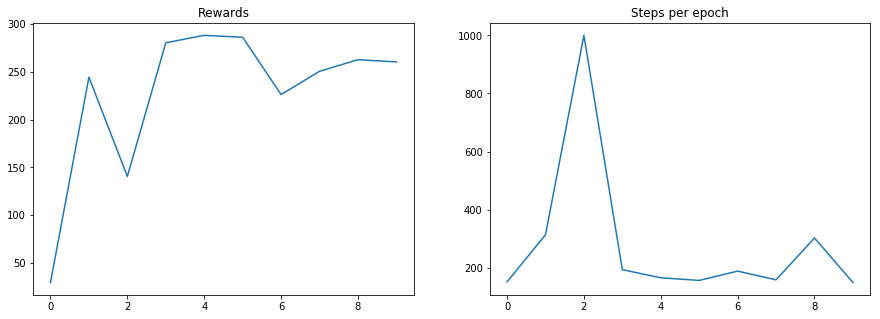

In [107]:
test(agent2, 10, fr=False)

**Как видим, робот садится 8 раз из 10. При этом при обучении часто получается reward > 200, а средний reward > 150**